In [179]:
# usual suspects
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import re

# NLP stuff:
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import pyLDAvis.sklearn

# LDA stuff:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.models import HdpModel
from gensim.models.nmf import Nmf

# Plotting stuff:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SILENCE!
import warnings
warnings.filterwarnings("ignore")

---
<div class="alert alert-block alert-info">


### About this notebook:
Here we look at topic modeling in the context of pure text-analytics (we saw it previously when working on content-based recommender system). See Page 214 of "Blueprints for Text Analytics Using Python"

Some of the theoretical content in this section (especially the matrix factorization sections) can be found in "Recommender Systems" by Aggarwal.

Other applications can be seen in Kim Falk's "Practical Recommender Systems".

</div>

---
### Import data:
Drop missing descriptions.

In [2]:
df = pd.read_csv('data/movie_descriptions.csv')
df.dropna(subset=['description'], inplace=True)
df.head()

,id,movie_id,imdb_id,title,description,genres
0,1,675353,12412888.0,Sonic the Hedgehog 2,"After settling in Green Hills, Sonic is eager ...","[28, 878, 35, 10751, 12]"
1,2,453395,9419884.0,Doctor Strange in the Multiverse of Madness,"Doctor Strange, with the help of mystical alli...","[14, 28, 12]"
2,3,629542,8115900.0,The Bad Guys,When the infamous Bad Guys are finally caught ...,"[16, 35, 28, 10751, 80]"
3,4,414906,1877830.0,The Batman,"In his second year of fighting crime, Batman u...","[80, 9648, 53]"
4,5,335787,1464335.0,Uncharted,"A young street-smart, Nathan Drake and his wis...","[28, 12]"


#### Vectorize tokens according to TF/IDF:

In [3]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['description'])
tfidf_text_vectors.shape

(9904, 7507)

---
---
<div class="alert alert-block alert-info">
    
### Apply Non-negative Matrix Factorization:
See Page 94 (latent factors) and 119 (NNMF) of Aggarwal.

According to Aggarwal, NNMF is great if interpretability is desired, something that is lost in Truncated SVD and other methods with fewer constraints (see page 219 of "Blueprints for Text Analytics Using Python", and pages 121, 127 of "Recommender Systems" by Aggarwal)
    
</div>

In [4]:
# call the factorization method with 10 "topics":
nmf_text_model = NMF(n_components=10, random_state=42)

# return the latent factor matrices (document-topic affinity, and word-topic affinity)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [5]:
# display topics:
def display_topics(model, features, no_top_words=5):
    # define df to hold results:
    df = pd.DataFrame()
    for topic, words in enumerate(model.components_):
        # define list to hold words and contributions:
        tokens = []
        percents = []
        
        # total number of words in topic:
        total = words.sum()
        # sort words by highest contribution (invert sort order):
        largest = words.argsort()[::-1]
        
        # sort and append results:
        for i in range(0, no_top_words):
            tokens.append(features[largest[i]])
            percents.append(abs(np.round(words[largest[i]]/total, 2)))
        
        # add topic words and their respective contributions to the dataframe:
        df["Topic %01d" % topic + ' - word'] = tokens
        df["Topic %01d" % topic + ' - contribution'] = percents
        
    return df

In [6]:
# show leading words per topic and their contributions:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,family,0.07,school,0.06,world,0.02,young,0.05,life,0.06,old,0.06,find,0.01,new,0.07,man,0.08,love,0.03
1,home,0.02,high,0.04,war,0.01,woman,0.04,finds,0.01,year,0.05,town,0.01,york,0.03,wife,0.02,story,0.03
2,house,0.01,student,0.02,earth,0.01,girl,0.01,career,0.00,mother,0.01,group,0.01,city,0.02,spider,0.01,true,0.01
3,father,0.01,students,0.01,save,0.01,mother,0.01,upside,0.00,father,0.01,small,0.01,home,0.00,death,0.01,film,0.01
4,son,0.00,teacher,0.01,battle,0.01,husband,0.01,turned,0.00,boy,0.01,friends,0.01,girlfriend,0.00,daughter,0.01,falls,0.01


In [7]:
# define function to get the size of the topics:
def get_topics_size(document_topic_matrix):
    # get the percent of documents assigned to each topic:
    data = np.round(document_topic_matrix.sum(axis=0)/document_topic_matrix.sum(), 2).reshape(1,10)
    # append to dataframe:
    df = pd.DataFrame(data, columns=["Topic " + str(x) for x in range(len(document_topic_matrix[0]))])

    return df

In [8]:
get_topics_size(W_text_matrix)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.06,0.07,0.14,0.1,0.09,0.08,0.19,0.09,0.07,0.1


<div class="alert alert-block alert-warning">
<b>Note:</b> According to "Blueprints for Text Analytics Using Python", no single topic should dominate the distribution. If so, then the number of topics should increase to make their representations more granular.
</div>

---
---
<div class="alert alert-block alert-info">
    
### Truncated SVD Method:
See page 219 of "Blueprints for Text Analytics Using Python", and page 113 of "Recommender Systems" by Aggarwal.
    
</div>

In [9]:
# call the SVD function and recover the latent factor matrices:
svd_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_matrix = svd_model.fit_transform(tfidf_text_vectors)
H_svd_matrix = svd_model.components_

In [10]:
# display topics:
display_topics(svd_model, tfidf_text_vectorizer.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,life,0.0,school,0.08,woman,0.03,love,1.52,young,0.64,old,0.09,new,0.05,family,0.22,friends,0.22,story,0.08
1,young,0.0,high,0.06,young,0.03,life,1.40,woman,0.56,year,0.09,young,0.04,story,0.05,town,0.19,love,0.04
2,new,0.0,year,0.03,man,0.02,story,1.09,school,0.36,world,0.07,love,0.03,school,0.04,find,0.16,true,0.03
3,world,0.0,old,0.03,life,0.02,man,0.84,high,0.28,boy,0.04,family,0.03,film,0.04,life,0.16,film,0.03
4,family,0.0,student,0.02,family,0.02,young,0.83,man,0.23,story,0.03,york,0.02,high,0.04,group,0.15,town,0.03


In [11]:
# define function to get the size of the topics:
def get_SVD_topics_size(svd_model):
    # get the percent of documents assigned to each topic:
    data = np.round(svd_model.singular_values_/100, 3).reshape(1,10)
    # append to dataframe:
    df = pd.DataFrame(data, columns=["Topic " + str(x) for x in range(len(svd_model.singular_values_))])

    return df

In [12]:
get_SVD_topics_size(svd_model)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.096,0.052,0.051,0.048,0.046,0.045,0.044,0.043,0.043,0.042


---
---
<div class="alert alert-block alert-info">
    
### LDA Method:
See page 221 of "Blueprints for Text Analytics Using Python"
    
</div>

In [32]:
# vectorize the words in each document:
count_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(df["description"])
count_vectors.shape

(9904, 7507)

In [33]:
# call the LDA transformation function:
lda_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_matrix = lda_model.fit_transform(count_vectors)
H_lda_matrix = lda_model.components_

In [37]:
# assign topics to each document:
def assing_topics_to_docs(df, lda_model, vectorized_docs):
    # define list to hold leading topics:
    lead_topics = []
    
    # get all topics for each doc:
    doc_topic = lda_model.transform(vectorized_docs)
    
    # for each doc, retrieve the leading topic:
    for n in range(doc_topic.shape[0]):
        topic_most_pr = doc_topic[n].argmax()
        lead_topics.append(topic_most_pr)
    
    # append topics to input df:
    df['lead topic'] = lead_topics
    
    return df

In [39]:
assing_topics_to_docs(df, lda_model, count_vectors).head(20)

,id,movie_id,imdb_id,title,description,genres,lead topic
0,1,675353,12412888.0,Sonic the Hedgehog 2,"After settling in Green Hills, Sonic is eager ...","[28, 878, 35, 10751, 12]",3
1,2,453395,9419884.0,Doctor Strange in the Multiverse of Madness,"Doctor Strange, with the help of mystical alli...","[14, 28, 12]",9
2,3,629542,8115900.0,The Bad Guys,When the infamous Bad Guys are finally caught ...,"[16, 35, 28, 10751, 80]",3
3,4,414906,1877830.0,The Batman,"In his second year of fighting crime, Batman u...","[80, 9648, 53]",3
4,5,335787,1464335.0,Uncharted,"A young street-smart, Nathan Drake and his wis...","[28, 12]",3
5,6,634649,10872600.0,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,"[28, 12, 878]",1
6,7,284052,1211837.0,Doctor Strange,"After his career is destroyed, a brilliant but...","[28, 12, 14, 878]",5
7,8,763285,4998632.0,Ambulance,"Decorated veteran Will Sharp, desperate for mo...","[28, 53, 80]",3
8,9,508947,8097030.0,Turning Red,Thirteen-year-old Mei is experiencing the awkw...,"[16, 10751, 35, 14]",5
9,10,406759,5834426.0,Moonfall,A mysterious force knocks the moon from its or...,"[878, 12, 28]",7


In [36]:
# display topics
display_topics(lda_model, count_vectorizer.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,love,0.02,school,0.01,day,0.01,police,0.01,film,0.01,old,0.01,life,0.01,man,0.01,mother,0.01,world,0.01
1,life,0.02,new,0.01,family,0.01,drug,0.01,life,0.01,world,0.01,world,0.01,find,0.01,family,0.01,team,0.01
2,young,0.01,high,0.01,new,0.01,crime,0.01,story,0.01,year,0.01,years,0.01,island,0.01,woman,0.01,new,0.01
3,man,0.01,town,0.01,young,0.01,killer,0.01,world,0.01,school,0.01,lives,0.01,town,0.01,young,0.01,high,0.01
4,girl,0.01,group,0.01,life,0.01,new,0.01,documentary,0.01,war,0.01,group,0.01,friends,0.01,father,0.01,time,0.01


In [17]:
# display topics by projecting feature-space in two dimensions:
lda_display = pyLDAvis.sklearn.prepare(lda_model, count_vectors, count_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

In [18]:
# alternative method of visualizing topics (using Tsne):
lda_tsne_display = pyLDAvis.sklearn.prepare(lda_model, count_vectors, count_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

---
---
<div class="alert alert-block alert-info">
    
### Wordclouds:
Wordclouds offer a great qualitative method of comparing the results of different topic models.
</div>

<div class="alert alert-block alert-warning">
<b>Note:</b> if many words have the same relative size, then the topic is not well-defined.
</div>

In [19]:
# show all topics wordclouds:
def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(5,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        # plt.savefig(f'topic{topic}.png')

In [141]:
# get all topic wordcloud figures:
def get_topic_wordclouds(model, features, no_top_words=40):
    # holds the generated clouds:
    figs = []
    
    # generate clouds:
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        fig = wc.generate_from_frequencies(size)
        figs.append(fig)
    return figs


### Compare topics:
<div class="alert alert-block alert-warning">
<b>Note: </b> The different models do not have corresponding topic model numbers, so it is necessary to inspect them separately to find their one-to-one mappings:
</div>

#### Get topics from NNMF topic model for comparison:

In [21]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,family,0.07,school,0.06,world,0.02,young,0.05,life,0.06,old,0.06,find,0.01,new,0.07,man,0.08,love,0.03
1,home,0.02,high,0.04,war,0.01,woman,0.04,finds,0.01,year,0.05,town,0.01,york,0.03,wife,0.02,story,0.03
2,house,0.01,student,0.02,earth,0.01,girl,0.01,career,0.00,mother,0.01,group,0.01,city,0.02,spider,0.01,true,0.01
3,father,0.01,students,0.01,save,0.01,mother,0.01,upside,0.00,father,0.01,small,0.01,home,0.00,death,0.01,film,0.01
4,son,0.00,teacher,0.01,battle,0.01,husband,0.01,turned,0.00,boy,0.01,friends,0.01,girlfriend,0.00,daughter,0.01,falls,0.01


#### Get topics from LDA topic model for comparison:

In [22]:
display_topics(lda_model, count_vectorizer.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,love,0.02,school,0.01,day,0.01,police,0.01,film,0.01,old,0.01,life,0.01,man,0.01,mother,0.01,world,0.01
1,life,0.02,new,0.01,family,0.01,drug,0.01,life,0.01,world,0.01,world,0.01,find,0.01,family,0.01,team,0.01
2,young,0.01,high,0.01,new,0.01,crime,0.01,story,0.01,year,0.01,years,0.01,island,0.01,woman,0.01,new,0.01
3,man,0.01,town,0.01,young,0.01,killer,0.01,world,0.01,school,0.01,lives,0.01,town,0.01,young,0.01,high,0.01
4,girl,0.01,group,0.01,life,0.01,new,0.01,documentary,0.01,war,0.01,group,0.01,friends,0.01,father,0.01,time,0.01


In [143]:
# get all topic wordcloud figures for the specified model:
nm_topic_wcs = get_topic_wordclouds(nmf_text_model, tfidf_text_vectorizer.get_feature_names(), no_top_words=40)

(-0.5, 959.5, 539.5, -0.5)

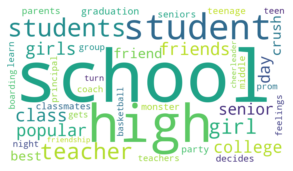

In [145]:
# plot specific cloud:
wc_nmf = nm_topic_wcs[1]
plt.figure(figsize=(5,5))
plt.imshow(wc_nmf, interpolation='bilinear')
plt.axis("off")

In [146]:
# get all topic wordcloud figures for the specified model:
lda_topic_wcs = get_topic_wordclouds(lda_model, count_vectorizer.get_feature_names(), no_top_words=40)

(-0.5, 959.5, 539.5, -0.5)

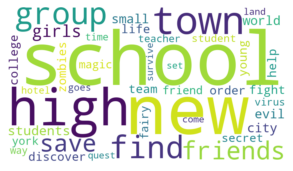

In [147]:
# plot specific cloud:
wc_lda = lda_topic_wcs[1]
plt.figure(figsize=(5,5))
plt.imshow(wc_lda, interpolation='bilinear')
plt.axis("off")

---
---
<div class="alert alert-block alert-info">
    
### Optimal Number of topics:
    
</div>

In [26]:
lda_model.perplexity(tfidf_text_vectors)

49329.804241913

In [27]:
lda_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LatentDirichletAllocation(n_components = n, random_state=42)
    lda_model.fit_transform(count_vectors)
    lda_perplexity = lda_model.perplexity(tfidf_text_vectors)
    lda_model_n.append((lda_model, lda_perplexity))

  0%|          | 0/16 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

In [40]:
lda_model_n

[(LatentDirichletAllocation(n_components=5, random_state=42),
  18840.6472800026),
 (LatentDirichletAllocation(n_components=6, random_state=42),
  23365.47815551065),
 (LatentDirichletAllocation(n_components=7, random_state=42),
  28696.10887554625),
 (LatentDirichletAllocation(n_components=8, random_state=42),
  34404.75406427173),
 (LatentDirichletAllocation(n_components=9, random_state=42),
  41455.07122213209),
 (LatentDirichletAllocation(random_state=42), 49329.804241913),
 (LatentDirichletAllocation(n_components=11, random_state=42),
  58161.97079276006),
 (LatentDirichletAllocation(n_components=12, random_state=42),
  68542.80006980413),
 (LatentDirichletAllocation(n_components=13, random_state=42),
  79887.46363552228),
 (LatentDirichletAllocation(n_components=14, random_state=42),
  93272.35314623038),
 (LatentDirichletAllocation(n_components=15, random_state=42),
  105926.89673308657),
 (LatentDirichletAllocation(n_components=16, random_state=42),
  124051.54374795078),
 (Lat

---
---
<div class="alert alert-block alert-info">
    
## Gensim Models:
See page 230 of "Blueprints for Text Analytics Using Python"
    
</div>

In [41]:
# create tokenized documents
gensim_text = [[w for w in re.findall(r'\b\w\w+\b' , document.lower()) if w not in stopwords] 
                           for document in df["description"]]

In [42]:
# generate dictionary, filter words based on thresholds (at least in 5 docs but no more than in 70% of all docs):
dict_gensim = Dictionary(gensim_text) 
dict_gensim.filter_extremes(no_below=5, no_above=0.7)

# convert to bag of words:
bow_gensim = [dict_gensim.doc2bow(text) for text in gensim_text]

In [44]:
# perform tf/idf on the corpus:
tfidf_gensim = TfidfModel(bow_gensim)
vectors_gensim = tfidf_gensim[bow_gensim]

---
### Gensim NMF:

In [45]:
# create a Gensim Non-negative Matrix Factorization model:
nmf_gensim = Nmf(vectors_gensim, num_topics=10, id2word=dict_gensim, kappa=0.1, eval_every=5, random_state=42) 

In [53]:
# display topics as df:
def display_topics_gensim(model):
    # define output df:
    df = pd.DataFrame()
    
    # iterate and append values:
    for topic in range(0, model.num_topics):
        # lists to hold values:
        words = []
        percents = []
        # append words and their contributions:
        for (word, prob) in model.show_topic(topic, topn=5):
            words.append(word)
            percents.append(prob)
            
        # add topic words and their respective contributions to the dataframe:
        df["Topic %01d" % topic + ' - word'] = words
        df["Topic %01d" % topic + ' - contribution'] = percents
        
    return df

In [54]:
display_topics_gensim(nmf_gensim)

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,man,0.015792,friend,0.012802,evil,0.009731,world,0.019990,find,0.007244,mysterious,0.010037,old,0.011582,story,0.011336,discover,0.008035,time,0.014047
1,woman,0.014590,best,0.011508,mother,0.006974,new,0.011271,way,0.006498,takes,0.007611,year,0.010880,father,0.009758,face,0.007438,family,0.010623
2,young,0.009699,order,0.009334,year,0.006416,high,0.009836,mission,0.006272,find,0.006364,life,0.010223,life,0.009019,team,0.007025,save,0.010598
3,group,0.007690,home,0.008530,old,0.006149,family,0.008174,killer,0.006229,town,0.006355,years,0.007167,true,0.007812,film,0.006741,way,0.006285
4,war,0.007385,away,0.007155,john,0.005899,school,0.006368,city,0.005764,turn,0.005844,daughter,0.007031,secret,0.007284,human,0.005901,earth,0.005612


In [55]:
# Get model coherence score:
nmf_gensim_coherence = CoherenceModel(model=nmf_gensim, texts=gensim_text, dictionary=dict_gensim, coherence='c_v')
nmf_gensim_coherence_score = nmf_gensim_coherence.get_coherence()
print(nmf_gensim_coherence_score)

0.2703300969356479


---
### Gensim LDA:

In [56]:
# create a gensim LDA model:
lda_gensim = LdaModel(corpus=bow_gensim, id2word=dict_gensim, chunksize=2000,
                      alpha='auto', eta='auto', iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

In [57]:
# display topics:
display_topics_gensim(lda_gensim)

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,documentary,0.013571,love,0.011009,king,0.013562,police,0.010300,life,0.017822,family,0.015963,school,0.021661,film,0.015222,world,0.020558,life,0.024841
1,star,0.009773,story,0.010690,new,0.010057,city,0.008177,story,0.015463,young,0.011935,high,0.017467,world,0.011259,war,0.011719,love,0.019831
2,shop,0.007111,sex,0.009092,queen,0.007403,crime,0.007928,love,0.011108,old,0.011564,life,0.011495,game,0.009012,group,0.009084,young,0.017156
3,footage,0.006462,film,0.009023,christmas,0.007197,drug,0.007567,true,0.009986,home,0.011130,new,0.010888,island,0.006498,earth,0.008736,father,0.012345
4,football,0.006458,women,0.008696,princess,0.007190,prison,0.007177,man,0.006616,house,0.009249,day,0.009603,united,0.006166,team,0.008530,woman,0.010243


In [58]:
# get LDA coherence score:
lda_gensim_coherence = CoherenceModel(model=lda_gensim, texts=gensim_text, dictionary=dict_gensim, coherence='c_v')
lda_gensim_coherence_score = lda_gensim_coherence.get_coherence()
print(lda_gensim_coherence_score)

0.3606322940920068


In [59]:
lda_gensim.alpha

array([0.21131866, 0.2749641 , 0.3344756 , 0.71892875, 0.28227845,
       0.842018  , 0.7812541 , 0.34199476, 0.90871096, 0.677135  ],
      dtype=float32)

In [61]:
# get average topic coherence:
top_topics = lda_gensim.top_topics(vectors_gensim, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -4.0457.


In [62]:
# get the coherence for each topic:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-2.0750540101650845, 'school high life new day'),
 (-2.2672302523181935, 'life story love true man'),
 (-2.3258905528630267, 'life love young father woman'),
 (-2.450676668298732, 'family young old home house'),
 (-2.805523119242063, 'world war group earth team'),
 (-2.97735427298363, 'police city crime drug prison'),
 (-3.208072619883707, 'love story sex film women'),
 (-5.184589633056037, 'king new queen christmas princess'),
 (-7.87438094210349, 'film world game island united'),
 (-9.288089074687244, 'documentary star shop footage football')]

---
### Optimize Number of LDA topics:

In [63]:
# iterate through several number of topics for each model and plot the result:
lda_model_n = []
for n in tqdm(range(5, 21)):
    # create model n:
    nlda_model = LdaMulticore(corpus=bow_gensim, id2word=dict_gensim, chunksize=2000,
                              eta='auto', iterations=400, num_topics=n, passes=20, 
                              eval_every=None, random_state=42)
    # get the coherence for model n:
    nlda_coherence = CoherenceModel(model=nlda_model, texts=gensim_text, 
                                    dictionary=dict_gensim, coherence='c_v')
    lda_model_n.append((n, nlda_model, nlda_coherence.get_coherence()))

  0%|          | 0/16 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n'>

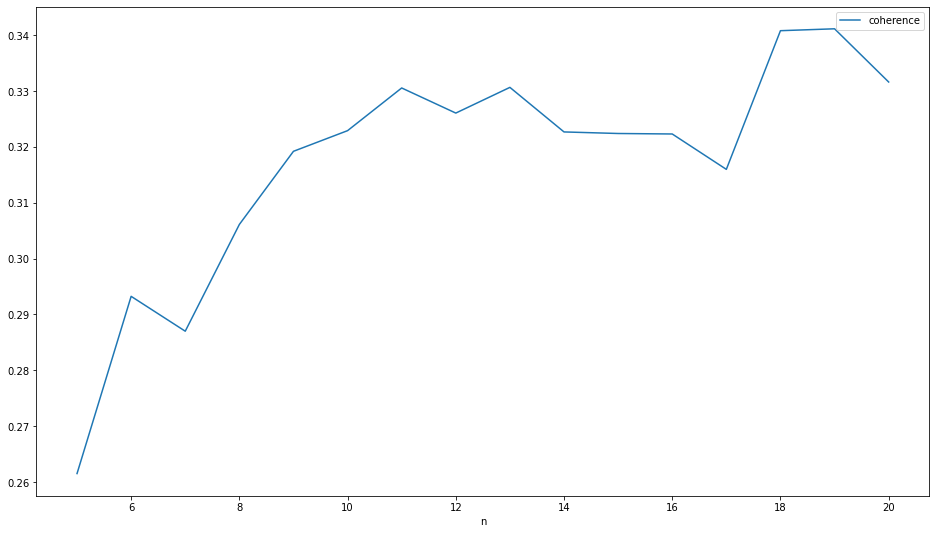

In [65]:
# plot results:
pd.DataFrame(lda_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))

In [94]:
# get the topics for model "18" (14 by index):
display_topics_gensim(lda_model_n[14][1])

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,...,Topic 14 - word,Topic 14 - contribution,Topic 15 - word,Topic 15 - contribution,Topic 16 - word,Topic 16 - contribution,Topic 17 - word,Topic 17 - contribution,Topic 18 - word,Topic 18 - contribution
0,team,0.007575,young,0.007427,son,0.009369,family,0.008441,man,0.008943,...,life,0.021082,film,0.013190,life,0.010328,world,0.016558,young,0.010125
1,friends,0.007403,world,0.006285,young,0.008142,young,0.006877,life,0.006309,...,young,0.011001,love,0.010867,game,0.008258,new,0.007002,year,0.007637
2,day,0.006373,girl,0.005970,world,0.007826,man,0.004943,time,0.006102,...,man,0.006878,story,0.010180,new,0.007344,help,0.005898,old,0.007068
3,find,0.005790,max,0.005948,new,0.007569,find,0.004591,car,0.005588,...,old,0.005726,world,0.009033,finds,0.006510,earth,0.005724,man,0.006465
4,world,0.005356,town,0.005838,mother,0.007543,new,0.004447,old,0.005487,...,story,0.005501,new,0.008381,family,0.005963,time,0.004948,family,0.006454


In [98]:
# get the top model's coherence:
lda_model_n[14][2]

0.34112258456655553

In [132]:
# create word cloud figs for all topics:
def wordcloud_topics_gensim(model, no_top_words=40):
    # save all figs in list:
    figs = []
    # iterate through each topic and get its size:
    for topic in range(0, model.num_topics):
        size = {}
        # append leading terms:
        for (word, prob) in model.show_topic(topic, topn=no_top_words):
            size[word] = prob
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        # append fig:
        figs.append(wc.generate_from_frequencies(size))
    # return all figs
    return figs

In [133]:
# get all wordcluds:
gensim_wordclouds = wordcloud_topics_gensim(lda_model_n[14][1])

(-0.5, 959.5, 539.5, -0.5)

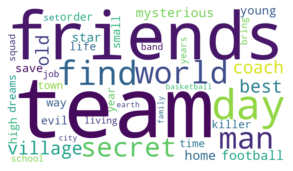

In [148]:
# get and plot specific topic wordcloud (0, in this case):
gensim_wc = gensim_wordclouds[0]
plt.figure(figsize=(5,5))
plt.imshow(gensim_wc, interpolation='bilinear')
plt.axis("off")

---
---
<div class="alert alert-block alert-info">
    
### HDP: Hierarchical Dirichlet Process 
See page 237 of "Blueprints for Text Analytics Using Python".
    
</div>

In [107]:
# generate HDP model:
hdp_gensim = HdpModel(corpus=bow_gensim, id2word=dict_gensim)

In [109]:
words = 8
pd.DataFrame([re.split(r" \+ |\*", t[1]) for t in hdp_gensim.print_topics(num_topics=20, num_words=words)])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.003,life,0.003,young,0.003,new,0.003,find,0.002,world,0.002,family,0.002,man,0.002,time
1,0.004,new,0.003,life,0.003,family,0.003,love,0.003,man,0.003,world,0.002,time,0.002,young
2,0.002,life,0.002,world,0.002,new,0.002,young,0.002,town,0.002,man,0.001,family,0.001,year
3,0.002,life,0.002,new,0.002,story,0.002,young,0.002,world,0.001,old,0.001,year,0.001,man
4,0.002,life,0.002,new,0.002,family,0.002,love,0.002,school,0.001,young,0.001,world,0.001,father
5,0.003,life,0.002,world,0.002,young,0.002,new,0.002,family,0.002,find,0.001,years,0.001,girl
6,0.002,world,0.002,life,0.001,new,0.001,find,0.001,young,0.001,family,0.001,way,0.001,man
7,0.002,life,0.002,world,0.002,new,0.001,find,0.001,young,0.001,battle,0.001,family,0.001,turn
8,0.001,life,0.001,new,0.001,family,0.001,young,0.001,world,0.001,woman,0.001,man,0.001,find
9,0.002,new,0.001,find,0.001,young,0.001,life,0.001,powerful,0.001,storm,0.001,security,0.001,world


In [110]:
pd.set_option('max_colwidth', 1000)
pd.DataFrame(hdp_gensim.print_topics(num_topics=40, num_words=10), columns=["topic", "words"]).set_index("topic")

,words
topic,
0,0.003*life + 0.003*young + 0.003*new + 0.003*find + 0.002*world + 0.002*family + 0.002*man + 0.002*time + 0.002*love + 0.002*old
1,0.004*new + 0.003*life + 0.003*family + 0.003*love + 0.003*man + 0.003*world + 0.002*time + 0.002*young + 0.002*find + 0.002*friends
2,0.002*life + 0.002*world + 0.002*new + 0.002*young + 0.002*town + 0.002*man + 0.001*family + 0.001*year + 0.001*find + 0.001*lives
3,0.002*life + 0.002*new + 0.002*story + 0.002*young + 0.002*world + 0.001*old + 0.001*year + 0.001*man + 0.001*friends + 0.001*film
4,0.002*life + 0.002*new + 0.002*family + 0.002*love + 0.002*school + 0.001*young + 0.001*world + 0.001*father + 0.001*high + 0.001*rachel
5,0.003*life + 0.002*world + 0.002*young + 0.002*new + 0.002*family + 0.002*find + 0.001*years + 0.001*girl + 0.001*man + 0.001*friends
6,0.002*world + 0.002*life + 0.001*new + 0.001*find + 0.001*young + 0.001*family + 0.001*way + 0.001*man + 0.001*austin + 0.001*magical
7,0.002*life + 0.002*world + 0.002*new + 0.001*find + 0.001*young + 0.001*battle + 0.001*family + 0.001*turn + 0.001*soon + 0.001*woman
8,0.001*life + 0.001*new + 0.001*family + 0.001*young + 0.001*world + 0.001*woman + 0.001*man + 0.001*find + 0.001*mechanical + 0.001*women


In [111]:
hdp_gensim.show_topic(0, topn=10)

[('life', 0.0031909152160442085),
 ('young', 0.0030241243620131425),
 ('new', 0.0029543411880192326),
 ('find', 0.002588716868492028),
 ('world', 0.002437995883903974),
 ('family', 0.002240252083576859),
 ('man', 0.0021385810874052598),
 ('time', 0.002137990550244101),
 ('love', 0.0021076399433612564),
 ('old', 0.0019532607233626606)]

In [112]:
def display_topics_gensim_hdp(model, num_topics):
    for topic in range(0, num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=10):
            print("  %s (%2.2f)" % (word, prob))

In [114]:
# display_topics_gensim_hdp(hdp_gensim, 50)

---
---
<div class="alert alert-block alert-info">
    
### Clustering:
See page 238 of "Blueprints for Text Analytics Using Python".
    
</div>

In [115]:
# initialize K-means model:
k_means = KMeans(n_clusters=10, random_state=42)
k_means.fit(tfidf_text_vectors)

KMeans(n_clusters=10, random_state=42)

<AxesSubplot:xlabel='cluster'>

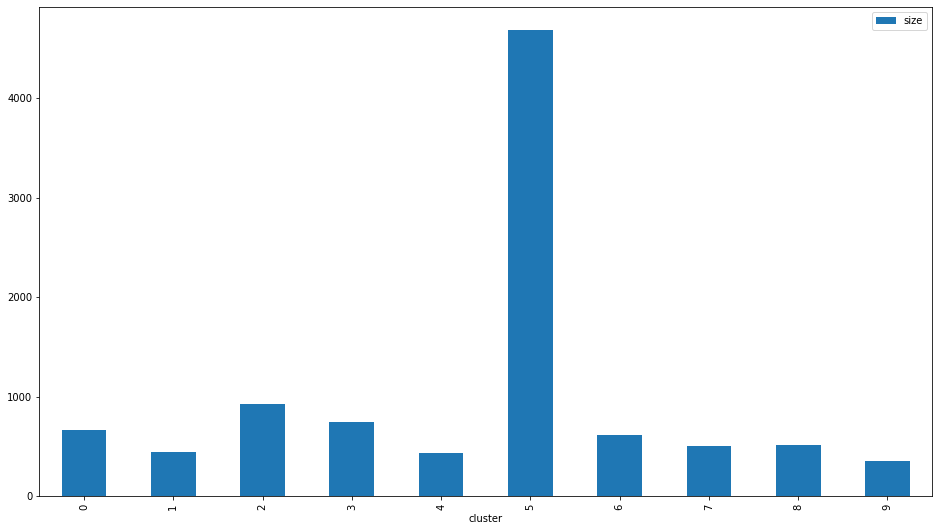

In [116]:
# visualize the size of all clusters:
# (by adding the tf/idf vectors of all documents in the cluster and keeping the largest values)
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
# fig.savefig("cluster-size.svg")

In [118]:
# get the counts:
np.unique(k_means.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 666,  443,  929,  749,  441, 4678,  616,  507,  517,  358]))

In [128]:
# plot specific cluster:
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    # define list to hold all figs:
    figs = []
    
    # iterate through each cluster:
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        
        # append leading words to cloud:
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        # append fig to list
        figs.append(wc)
        
    # return all figs:
    return figs

In [130]:
# get all cluster wordclous:
cluster_fig = wordcloud_clusters(k_means, tfidf_text_vectors, tfidf_text_vectorizer.get_feature_names())

(-0.5, 959.5, 539.5, -0.5)

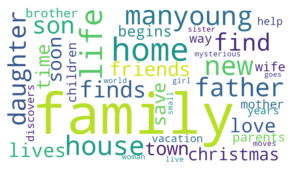

In [149]:
# plot specific cluster: 
cluster_wc = cluster_fig[0]
plt.figure(figsize=(5, 5))
plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis("off")

In [154]:
# append cluster label to original dataset:
def assign_clusters(df, kmeans_model):
    # assign new column to df:
    df['kmeans_cluster'] = k_means.labels_
    
    return df

In [155]:
assign_clusters(df, k_means)

,id,movie_id,imdb_id,title,description,genres,lead topic,kmeans_cluster
0,1,675353,12412888.0,Sonic the Hedgehog 2,"After settling in Green Hills, Sonic is eager to prove he has what it takes to be a true hero. His test comes when Dr. Robotnik returns, this time with a new partner, Knuckles, in search for an emerald that has the power to destroy civilizations. Sonic teams up with his own sidekick, Tails, and together they embark on a globe-trotting journey to find the emerald before it falls into the wrong hands.","[28, 878, 35, 10751, 12]",3,5
1,2,453395,9419884.0,Doctor Strange in the Multiverse of Madness,"Doctor Strange, with the help of mystical allies both old and new, traverses the mind-bending and dangerous alternate realities of the Multiverse to confront a mysterious new adversary.","[14, 28, 12]",9,7
2,3,629542,8115900.0,The Bad Guys,"When the infamous Bad Guys are finally caught after years of countless heists and being the world’s most-wanted villains, Mr. Wolf brokers a deal to save them all from prison.","[16, 35, 28, 10751, 80]",3,3
3,4,414906,1877830.0,The Batman,"In his second year of fighting crime, Batman uncovers corruption in Gotham City that connects to his own family while facing a serial killer known as the Riddler.","[80, 9648, 53]",3,8
4,5,335787,1464335.0,Uncharted,"A young street-smart, Nathan Drake and his wisecracking partner Victor “Sully” Sullivan embark on a dangerous pursuit of “the greatest treasure never found” while also tracking clues that may lead to Nathan’s long-lost brother.","[28, 12]",3,2
...,...,...,...,...,...,...,...,...
9995,9996,576040,9228950.0,Malibu Rescue,"When a long list of shenanigans lands Tyler in hot water, he’s forced to suit up and spend his summer training for an elite junior lifeguard program.","[28, 35, 10751]",8,5
9996,9997,12797,995039.0,Ghost Town,"A spirited romantic comedy, Ghost Town is the story of Bertram Pincus (Ricky Gervais), a cranky Manhattan dentist who develops the unwelcome ability to see dead people. Really annoying dead people. But, when a smooth-talking ghost (Greg Kinnear) traps Bertram into a romantic scheme involving his widow Gwen (Tea Leoni), they are entangled in a hilarious predicament between the now and the hereafter!","[35, 14, 10749]",6,5
9997,9998,8198,258068.0,The Quiet American,"A stylish political thriller where love and war collide in Southeast Asia. Set in early 1950s Vietnam, a young American becomes entangled in a dangerous love triangle when he falls for the beautiful mistress of a British journalist. As war is waged around them, these three only sink deeper into a world of drugs, passion, and betrayal where nothing is as it seems.","[10749, 53, 18]",0,3
9998,9999,43643,111701.0,White Fang 2: Myth of the White Wolf,"A boy and his dog, White Fang, must try to save the noble Haida tribe from evil white men in turn-of-the-century Alaska.","[12, 10751]",1,5


In [177]:
bigram = Phrases(gensim_text, min_count=1, threshold=2)

In [181]:
bigram_phraser = Phraser(bigram)
bigram_phraser

In [191]:
bigram_phraser[gensim_text[3]]

['second_year',
 'fighting_crime',
 'batman',
 'uncovers',
 'corruption',
 'gotham_city',
 'connects',
 'family',
 'facing',
 'serial_killer',
 'known',
 'riddler']

---
---
<div class="alert alert-block alert-info">
    
## Gensim Bi-Gram Models:
In the cells below, we consider several models built using unigrams and bigrams as opposed to only unigrams as we have done until now. This should reduce the complexity of the models, as well as provide us with better topics and clusters. 
    
See "further ideas" page 242 of "Blueprints for Text Analytics Using Python"
    
</div>

#### Pre-process text:

In [197]:
# create tokenized documents
gensim_text = [[w for w in re.findall(r'\b\w\w+\b' , document.lower()) if w not in stopwords] 
                           for document in df["description"]]

# generate bigrams:
gensim_bigrams = Phrases(gensim_text, min_count=1, threshold=2)

# generate bigram tokens:
bigram_token = []
for doc in gensim_text:
    bigram_token.append(gensim_bigrams[doc])

# generate dictionary, filter words based on thresholds (at least in 5 docs but no more than in 70% of all docs):
dict_gensim_bigrams = Dictionary(bigram_token) 
dict_gensim_bigrams.filter_extremes(no_below=5, no_above=0.7)

# convert bigram tokens to bag of words:
bow_gensim_bigram = [dict_gensim_bigrams.doc2bow(text) for text in gensim_text]

# perform tf/idf on the corpus:
tfidf_gensim_bigram = TfidfModel(bow_gensim_bigram)
vectors_gensim_bigram = tfidf_gensim_bigram[bow_gensim_bigram]

#### NNMF Model:

In [204]:
# create a Gensim Non-negative Matrix Factorization model for the bigrams corpus:
nmf_gensim_bigram = Nmf(vectors_gensim_bigram, num_topics=10, id2word=dict_gensim_bigrams, kappa=0.1, eval_every=5, random_state=42) 

In [205]:
display_topics_gensim(nmf_gensim_bigram)

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,school,0.020319,friends,0.009979,young,0.014855,wife,0.010497,world,0.016553,love,0.017745,family,0.013073,new,0.017219,man,0.010673,old,0.010461
1,high,0.017727,gang,0.008473,mother,0.013671,island,0.007776,find,0.012545,war,0.012449,young,0.011806,time,0.013302,group,0.007524,story,0.009171
2,world,0.009635,deadly,0.006595,woman,0.013212,help,0.007742,woman,0.008603,forces,0.008139,father,0.008268,girl,0.009256,lives,0.007483,team,0.009077
3,order,0.007695,goes,0.006532,daughter,0.007832,town,0.007573,discovers,0.008093,story,0.008120,life,0.008145,mysterious,0.008487,planet,0.006977,home,0.008875
4,old,0.006859,stop,0.006271,finds,0.007079,lost,0.006449,life,0.007455,man,0.007591,son,0.007560,york,0.008101,earth,0.006969,true,0.008636


In [206]:
# Get model coherence score:
nmf_gensim_coherence_bi = CoherenceModel(model=nmf_gensim_bigram, texts=gensim_text, dictionary=dict_gensim_bigrams, coherence='c_v')
nmf_gensim_coherence_score_bi = nmf_gensim_coherence_bi.get_coherence()
print(nmf_gensim_coherence_score_bi)

0.30402883928235613


#### LDA Model:

In [207]:
# create a gensim LDA model:
lda_gensim_bigram = LdaModel(corpus=bow_gensim_bigram, id2word=dict_gensim_bigrams, chunksize=2000,
                             alpha='auto', eta='auto', iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

In [208]:
display_topics_gensim(lda_gensim_bigram)

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,school,0.056128,war,0.017669,town,0.037656,life,0.015110,earth,0.022692,group,0.016028,weekend,0.011326,alex,0.008264,film,0.018155,police,0.020671
1,high,0.038157,monster,0.016425,night,0.019583,young,0.012301,planet,0.013546,evil,0.014491,fairy,0.009785,race,0.007406,game,0.010616,murder,0.017852
2,christmas,0.021267,machine,0.011362,small,0.015563,new,0.010362,mission,0.009978,battle,0.013613,dealer,0.008869,early,0.006998,friends,0.009630,gang,0.015834
3,teacher,0.017457,soldiers,0.011043,house,0.008550,family,0.010052,alien,0.009801,world,0.011843,shark,0.008056,driver,0.006817,series,0.009587,crime,0.015686
4,students,0.014474,ii,0.010257,begins,0.008304,man,0.009574,team,0.009653,fight,0.010391,fly,0.007123,team,0.006747,new,0.008829,agent,0.015126


In [209]:
# Get model coherence score:
lda_gensim_coherence_bi = CoherenceModel(model=lda_gensim_bigram, texts=gensim_text, dictionary=dict_gensim_bigrams, coherence='c_v')
lda_gensim_coherence_score_bi = lda_gensim_coherence_bi.get_coherence()
print(lda_gensim_coherence_score_bi)

0.43995429884487036


<div class="alert alert-block alert-warning">
<b>Note:</b> if we compare the "coherence" of the models above, we can see that even without any search for optimal number of topics, the coherence of the bigram models is already considerably higher that in the plain unigram models.
</div>

In [210]:
# get all wordcluds:
gensim_wordclouds_bi = wordcloud_topics_gensim(lda_gensim_bigram)

(-0.5, 959.5, 539.5, -0.5)

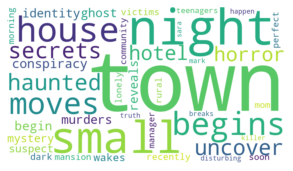

In [218]:
# get and plot specific topic wordcloud (0, in this case):
gensim_wc_bi = gensim_wordclouds_bi[2]
plt.figure(figsize=(5,5))
plt.imshow(gensim_wc_bi, interpolation='bilinear')
plt.axis("off")

---
---
<div class="alert alert-block alert-info">
    
## SciKit Bi-Gram Models:
Same as previous bigram models, but using SciKit learn.
    
See "further ideas" page 242 of "Blueprints for Text Analytics Using Python"
    
</div>

In [233]:
# vectorize tokens using ngrams:
tfidf_text_vectorizer_bi = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(1,2))
tfidf_text_vectors_bi = tfidf_text_vectorizer_bi.fit_transform(df['description'])
tfidf_text_vectors_bi.shape

(9904, 9416)

#### NNMF Model:

In [234]:
# call the factorization method with 10 "topics":
nmf_text_model_bi = NMF(n_components=10, random_state=42)

# return the latent factor matrices (document-topic affinity, and word-topic affinity)
W_text_matrix_bi = nmf_text_model_bi.fit_transform(tfidf_text_vectors_bi)
H_text_matrix_bi = nmf_text_model_bi.components_

In [235]:
# show leading words per topic and their contributions:
display_topics(nmf_text_model_bi, tfidf_text_vectorizer_bi.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,find,0.01,school,0.05,old,0.05,young,0.05,new,0.05,life,0.03,world,0.04,killer,0.01,family,0.04,town,0.05
1,friends,0.01,high,0.04,year,0.05,woman,0.03,york,0.03,love,0.02,war,0.03,police,0.01,home,0.01,small,0.04
2,group,0.01,high school,0.03,year old,0.04,man,0.02,new york,0.03,story,0.01,world war,0.02,murder,0.01,father,0.01,small town,0.03
3,earth,0.01,student,0.01,boy,0.01,young woman,0.02,city,0.02,true,0.01,war ii,0.01,wife,0.01,mother,0.01,sheriff,0.01
4,save,0.00,students,0.01,girl,0.01,young man,0.01,york city,0.02,film,0.00,ii,0.01,crime,0.01,house,0.01,local,0.00


#### LDA Model:

In [236]:
# vectorize the words in each document:
count_vectorizer_bi = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(1,2))
count_vectors_bi = count_vectorizer_bi.fit_transform(df["description"])
count_vectors_bi.shape

# call the LDA transformation function:
sk_lda_model_bi = LatentDirichletAllocation(n_components = 10, random_state=42)
sk_W_lda_matrix_bi = sk_lda_model_bi.fit_transform(count_vectors_bi)
sk_H_lda_matrix_bi = sk_lda_model_bi.components_

# display topics
display_topics(sk_lda_model_bi, count_vectorizer_bi.get_feature_names())

,Topic 0 - word,Topic 0 - contribution,Topic 1 - word,Topic 1 - contribution,Topic 2 - word,Topic 2 - contribution,Topic 3 - word,Topic 3 - contribution,Topic 4 - word,Topic 4 - contribution,Topic 5 - word,Topic 5 - contribution,Topic 6 - word,Topic 6 - contribution,Topic 7 - word,Topic 7 - contribution,Topic 8 - word,Topic 8 - contribution,Topic 9 - word,Topic 9 - contribution
0,prison,0.01,world,0.01,old,0.02,young,0.01,school,0.01,young,0.01,man,0.01,world,0.01,world,0.01,family,0.01
1,police,0.00,war,0.01,year,0.02,life,0.01,life,0.01,new,0.01,love,0.01,new,0.01,race,0.01,martial,0.00
2,agent,0.00,new,0.01,year old,0.01,family,0.01,high,0.01,man,0.01,story,0.01,save,0.01,story,0.01,money,0.00
3,years,0.00,team,0.01,school,0.01,girl,0.01,high school,0.01,find,0.01,group,0.01,gang,0.01,years,0.01,boss,0.00
4,murder,0.00,battle,0.01,life,0.01,woman,0.01,new,0.00,life,0.00,world,0.01,help,0.00,earth,0.01,arts,0.00


In [237]:
# display topics by projecting feature-space in two dimensions:
lda_display_bi = pyLDAvis.sklearn.prepare(sk_lda_model_bi, count_vectors_bi, count_vectorizer_bi, sort_topics=False)
pyLDAvis.display(lda_display_bi)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im